In [1]:
from pde_rk import pde_rk
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
%matplotlib notebook

## Two species model

A model with a mixture of fast and slow exchanging molecules (for supplementary figure 4). Molecules bind to the membrane with a constant on rate, and are assigned to either a fast exchanging or slow exchanging state with a specified probability.

Specify the core parameters below:

In [2]:
D = 0.1 ### <- diffusion coefficient on the membrane (µm^2/s)
koff1 = 1e-3  ### <- off rate of the slow species
koff2 = 1  ### <- off rate of the fast species
frac_fast = 0.99  ### <- fraction of fast events

### Cortical flow profile

Using the same flow profile as before

In [3]:
def generate_flow_profile(A=74, B=391, C=1000, D=100):
    X = np.linspace(0, 60, 100)
    v = (((60-X) / A) * np.exp(-((60-X) ** 2) / B)) - ((X / C) * np.exp(-(X ** 2) / D))
    return v

### PDE model



In [4]:
class Model:
    def __init__(self, Dm, kon1, kon2, koff1, koff2, psi=0.174, tot=1.56):
        
        # Diffusion
        self.Dm = Dm

        # Flow profile
        self.flow_profile = generate_flow_profile()

        # Membrane exchange
        self.kon1 = kon1
        self.koff1 = koff1
        self.kon2 = kon2
        self.koff2 = koff2

        # Misc
        self.tot = tot # total amount of protein
        self.psi = psi # surface area to volume ratio
        self.xsteps = 100 # number of positions to split the spatial dimension into
        self.L = 60 # system length
        self.deltax = self.L / self.xsteps # spatial step

    def diffusion(self, concs, dx):
        concs_ = np.r_[concs[0], concs, concs[-1]] # Dirichlet boundary conditions
        d = concs_[:-2] - 2 * concs_[1:-1] + concs_[2:]
        return d / (dx ** 2)

    def flow(self, concs, dx):
        # Calculates the gradient in both directions and takes the average
        return (np.r_[0, np.diff(concs * self.flow_profile)] +
                  np.r_[np.diff(concs * self.flow_profile), 0]) / (2 * dx)

    def dxdt(self, X):
        m1 = X[0]
        m2 = X[1]
        c = self.tot - self.psi * (np.mean(m1) + np.mean(m2))

        flow1 = self.flow(m1, self.deltax)
        flow2 = self.flow(m2, self.deltax)

        dm1 = (self.kon1 * c) - (self.koff1 * m1) + (self.Dm * self.diffusion(m1, self.deltax)) + flow1
        dm2 = (self.kon2 * c) - (self.koff2 * m2) + (self.Dm * self.diffusion(m2, self.deltax)) + flow2
        return [dm1, dm2]

    def dxdt_no_flow(self, X):
        m1 = X[0]
        m2 = X[1]
        c = self.tot - self.psi * (np.mean(m1) + np.mean(m2))

        dm1 = (self.kon1 * c) - (self.koff1 * m1) + (self.Dm * self.diffusion(m1, self.deltax))
        dm2 = (self.kon2 * c) - (self.koff2 * m2) + (self.Dm * self.diffusion(m2, self.deltax))
        return [dm1, dm2]

    def run(self, Tmax, t_eval=None, killfunc=None, maxstep=None, rk=True, flow=True, start=None):
        # Evaluation times
        if t_eval is None:
            t_eval = np.arange(0, Tmax + 0.0001, Tmax)

        # Starting conditions
        if start is None:
            start = [np.zeros([self.xsteps]), np.zeros([self.xsteps])]

        # Flow regime
        if flow:
            func = self.dxdt
        else:
            func = self.dxdt_no_flow

        soln, time, solns, times = pde_rk(dxdt=func, X0=start,
                                         Tmax=Tmax, deltat=0.01, t_eval=t_eval, killfunc=killfunc,
                                         maxstep=maxstep, rk=rk)
        return soln, time, solns, times

### Simulate

In [5]:
# Build the class
m = Model(Dm=0.1, kon1=1-frac_fast , kon2=frac_fast, koff1=koff1, koff2=koff2, psi=0.174, tot=1.56)

# Run without flow (to equilibrate prior to flow)
soln_pre_flow, _, _, _ = m.run(Tmax=500, flow=False, t_eval=np.arange(0, 501, 10))

# Run with flow
soln, time, solns, times = m.run(Tmax=500, flow=True, start=soln_pre_flow, t_eval=np.arange(0, 501, 10))

#### Interactive figure to view simulation results

In [6]:
def interactive_fig(solns, times):
    fig, ax = plt.subplots()
    ymax = 1.1 * np.max(solns[0] + solns[1])
    @widgets.interact(Time=(0, times[-1], 10))
    def update(Time=0):
        ax.clear()
        tpoint = np.argmin(abs(times - Time))
        x = np.linspace(0, 60, 100)
        ax.plot(x, solns[0][tpoint] + solns[1][tpoint], label='Total')
        ax.plot(x, solns[1][tpoint], c='tab:orange', linestyle='--', label='Fast state')
        ax.plot(x, solns[0][tpoint], c='tab:orange', label='Slow state')

        ax.set_ylim(0, ymax)
        ax.set_xlabel('Position (x)')
        ax.set_ylabel('Membrane concentration')
        ax.tick_params(axis='both', labelsize=8)
        ax.legend(frameon=False, fontsize=8, loc='upper right')

    fig.set_size_inches(4,3)
    fig.tight_layout()

<IPython.core.display.Javascript object>


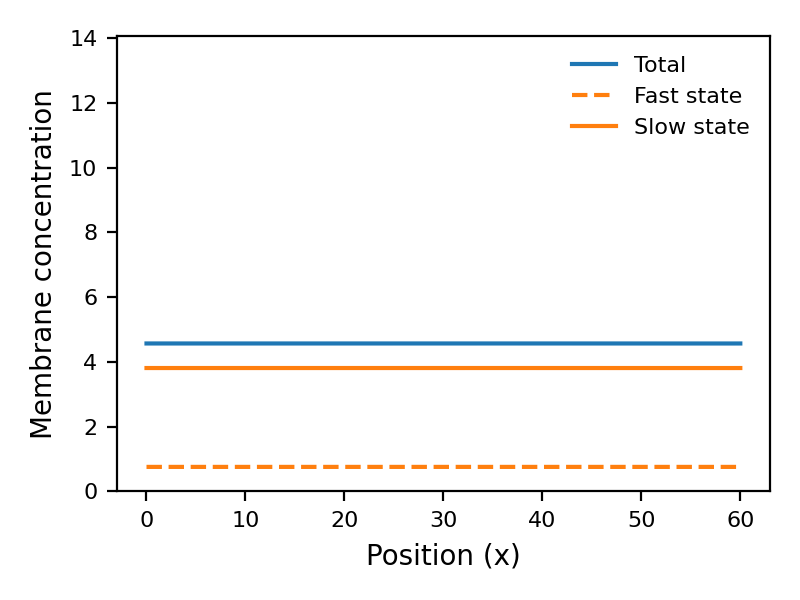

interactive(children=(FloatSlider(value=0.0, description='Time', max=500.0000000000452, step=10.0), Output()),…

In [7]:
interactive_fig(solns, times)